# 4. DNA-DSB InDelsTopo Average Analysis on Yeast

In this notebook we analyze DNA double-strand break (DSB) repair data from [Jeon et al.](https://www.nature.com/articles/s41467-024-51457-9) using the **Insertion Chain Complex**, implemented in the package **InDelsTopo**. We work with the averaged data from four biological replicates per experimental condition, preprocessed in `1_Preprocess_Data.ipynb`.

In the underlying experiments, DSBs are introduced at prescribed positions along a DNA molecule (A, B, AB, or C/D), together with additional experimental modifiers such as RNA orientation (sense/antisense), cellular background (WT/KO), RNase context (R1/R2), RNA structure (branch or branchΔ), and transcriptional activity (presence or absence of a CMV promoter). After repair, DNA sequences are obtained by high-throughput sequencing and aligned to the original reference sequence.

The input data analyzed here consists of frequency tables of repaired DNA sequences (`window_freq_withoutSubst.tsv`), generated using the pipeline of [Channagiri et al.](https://github.com/tchannagiri/DSBplot) and reproduced in the repository of [Jeon et al.](https://github.com/xph9876/RNA-mediated_DSB_repair/). From these data, we isolate the DNA subsequences inserted at the repair site and, for each experimental design, retain only sequences present in all four replicates with an average frequency of at least $10^{-5}$.

The resulting averaged insertion distributions are then used as input for the InDelsTopo analysis.

In [1]:
import pandas as pd
pd.options.display.float_format = '{:.2e}'.format
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

from utils.utils import *

from InDelsTopo import Filtration

with open('data/preprocessed/Yeast_experiments_average.pickle', 'rb') as handle:
    Average_Experiments = pkl.load(handle)

## A. Computing Filtrations and Topological Signatures

We begin by loading the preprocessed data from  
`data/preprocessed/Yeast_experiments_average.pickle`.

For each experiment, we retain only insertion subsequences with a frequency of at least $10^{-5}$ and normalize the remaining frequencies so that they sum to 1. Using these normalized distributions, we construct a **filtration of insertion chain complexes** with the `Filtration` object from **InDelsTopo**, up to dimension `max_dim = 10`. The experimental condition associated with each filtration is stored as the attribute `K.exp_name`.

As a topological signature, we compute a **logarithmic Euler characteristic curve** for each filtration. Specifically, we sample `sample_n` values logarithmically in the interval $[10^{-7}, 1]$ and evaluate the Euler characteristic of the filtration at each sampled value. These curves are stored as rows of the data matrix $X$.

In [2]:
sample_n=50
min_threshold=1e-5
max_dim=10

#x-coordinates for computing Euler Curves
xs=np.power(10,np.linspace(-7,0,num=sample_n))

#Create matrix to save Euler Curves, and lists to sava labels and complexes
X=np.zeros((len(Average_Experiments),sample_n))
labels=[]
Filtrations=[]

#Create Complexes and save them
id_exp=0
for Experiment in Average_Experiments:
    exp_name=Experiment['exp_name']
    labels.append(exp_name)
    Table=Experiment['table'].sort_values('avg_freq',ascending=True)

    #Filter by threshold for average frequency
    Table=Table[Table.avg_freq>=min_threshold]

    Words=list(Table.sequence)
    Freqs=np.array(Table.avg_freq)

    #normalize Freqs
    Freqs=Freqs/sum(Freqs)

    #Create Filtration
    K=Filtration()
    K.compute_d_skeleton(Words,Freqs,max_dim)
    K.exp_name=exp_name
    Filtrations.append(K)

    xs,ys=K.get_euler_curve(xs)

    X[id_exp]=ys
    id_exp+=1

Product symbol set to (concatenation)
Product symbol set to (concatenation)
Product symbol set to (concatenation)
Product symbol set to (concatenation)
Product symbol set to (concatenation)
Product symbol set to (concatenation)
Product symbol set to (concatenation)
Product symbol set to (concatenation)
Product symbol set to (concatenation)
Product symbol set to (concatenation)
Product symbol set to (concatenation)
Product symbol set to (concatenation)


## B. Hierarchical Clustering and Projection

We perform hierarchical clustering using `AgglomerativeClustering` from `sklearn` with `average` linkage. The resulting hierarchy is visualized as a dendrogram, where each leaf corresponds to an average experiment and is labeled by its experimental design.

The clustering shows an almost clean separation by antisense vs sense construction. To highlight this structure, experiments are colored accordingly.

We also visualize the data in two dimensions using **t-SNE**. In the projected space, averaged experiments are again colored, and a clear clustering by break location is observed.

### Conclusion

These results provide further evidence that DNA repair outcomes are influenced by the **local DNA sequence at the break site**. In particular, the topological signatures derived from collections of insertion subsequences cluster according to sense vs antisense.

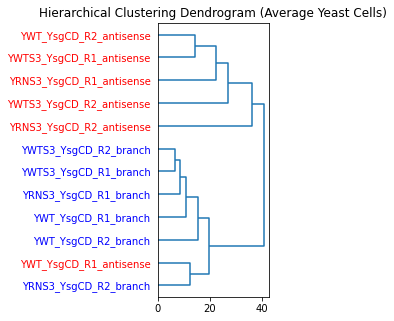

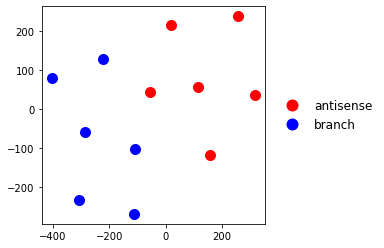

In [3]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE

#Compute clustering and plot
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None,linkage='average')
model = model.fit(X)

#labels=[a[0] for a in All_persistent_diagrams[:28]]
plt.figure(figsize=(2,10))
plt.title("Hierarchical Clustering Dendrogram (Average Yeast Cells)")
fig=plot_dendrogram(model, truncate_mode="level",labels=labels,
                leaf_font_size=10, color='yeast')

tSNE=TSNE(metric='euclidean',perplexity=10,n_components=2,random_state=123)
Y=tSNE.fit_transform(X)

plot_projection(Y,labels, figsize=(4,4),color='yeast')

## C. Betti Numbers

We computed the homology of the Insertion Chain Complexes for the experiments (at frequency = 1) and report both their Betti numbers and the dimensions of the complexes. We observe:

1. The dimensions of the resulting complexes range from 2 to 4.  
2. Most complexes have more than one connected component ($B_0 > 1$). This is likely due to noise, as random sequences that do not connect to any other sequences contribute no information about the underlying structure.  
3. All experiments exhibit no higher-dimensional homology. 

### Conclusions

The minimal dimension of 2 supports our approach of generalizing the Insertion Graph to a higher-dimensional object.  

Theorem 5.12 from (Jonoska, Martinez-Figueroa, Saito) [https://arxiv.org/abs/2509.12607] implies that if we observe most intermediate subsequences between the empty sequence (perfect repair) and the maximal inserted subsequences then all homology should vanish. This is what we expect if insertions occur randomly without bias. Since higher-dimensional homology vanishes for our experiments, this provides evidence that insertions are occurring in an unbiased manner. 

In [4]:
#Finally we compute the betti numbers of these Complexes
Table=[]
for label, K in zip(labels,Filtrations):
    betti_numbers=K.get_complex().get_betti_numbers_z2()
    Table.append([label, K.dim]+[safe_get(betti_numbers,i) for i in range(5)])

Table=pd.DataFrame(Table)
Table.columns = ['Experiment', 'Dimension','B_0', 'B_1','B_2','B_3','B_4']
Table

,Experiment,Dimension,B_0,B_1,B_2,B_3,B_4
0,YRNS3_YsgCD_R1_antisense,2,2,0,0,0,0
1,YRNS3_YsgCD_R1_branch,3,2,0,0,0,0
2,YRNS3_YsgCD_R2_antisense,3,5,0,0,0,0
3,YRNS3_YsgCD_R2_branch,3,2,0,0,0,0
4,YWTS3_YsgCD_R1_antisense,4,4,0,0,0,0
5,YWTS3_YsgCD_R1_branch,2,2,0,0,0,0
6,YWTS3_YsgCD_R2_antisense,4,9,0,0,0,0
7,YWTS3_YsgCD_R2_branch,3,2,0,0,0,0
8,YWT_YsgCD_R1_antisense,3,2,0,0,0,0
9,YWT_YsgCD_R1_branch,3,2,0,0,0,0
